<a href="https://colab.research.google.com/github/haresh93/EVA-submissions/blob/master/S5/EVA4_Session_5_Step_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **TARGET**
1. Getting the Basic Skeleton of the Network right
2. Without any regularization 

### **RESULTS**
1. Parameters: 114.3k
2. Best Training Accuracy: 99.45%
3. Best Test Accuracy: 99.01%

### **Analysis**
1. Still Heavy
2. Model is weaker than the previous model for sure as the accuracy at the first epoch is 66.44%.
2. Model is sort of overfitted.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train and Test Transforms
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
])

In [0]:
# Train and Test Datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                    transform=test_transforms)


In [0]:
# Train and Test Data Loaders
torch.manual_seed(1)

if torch.cuda.is_available():
  torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
Numpy Shape -  (60000, 28, 28)
Tensor Shape -  torch.Size([60000, 28, 28])
Min -  tensor(-0.4242)
Max -  tensor(2.8215)
Mean -  tensor(0.0009)
Std -  tensor(1.0000)
Var -  tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


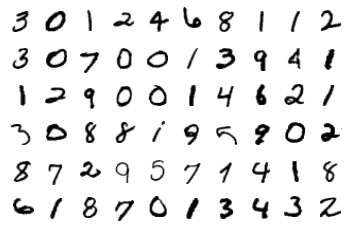

In [0]:
# Data Statistics

train_data = train_dataset.train_data

train_data = train_dataset.transform(train_data.numpy())

print("[Train]")
print("Numpy Shape - ", train_dataset.train_data.cpu().numpy().shape)
print("Tensor Shape - ", train_dataset.train_data.size())
print("Min - ", torch.min(train_data))
print("Max - ", torch.max(train_data))
print("Mean - ", torch.mean(train_data))
print("Std - ", torch.std(train_data))
print("Var - ", torch.var(train_data))


train_iter = iter(train_dataloader)

images, labels = train_iter.next()

print(images.shape)
print(labels.shape)

import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60

for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap = "gray_r")

In [0]:
# The Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3), # Convolution layer 1 - input 28 x 28 x 1 : Output 26 x 26 x 32 : RF 3 x 3
            nn.ReLU(), 
            nn.Conv2d(32, 32, 3), # Convolution Layer 2 - input 26 x 26 x 32 : Output 24 x 24 x 32 : RF 5 x 5
            nn.ReLU(), 
            nn.Conv2d(32, 32, 3), # Convolution Layer 3 - input 24 x 24 x 32 : Output 22 x 22 x 32 : RF 7 x 7
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Max Pooling Layer - input 22 x 22 x 32 : Output 11 x 11 x 32 : RF 8 x 8
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # Convolution Layer 4 - input 11 x 11 x 32 : Output 9 x 9 x 64 : RF 12 x 12
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), # Convolution Layer 5 - input 9 x 9 x 64 : Output 7 x 7 x 64 : RF 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), # Convolution Layer 6 - input 7 x 7 x 64 : Output 5 x 5 x 64 : RF 20 x 20
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 10, 1), # Convolution Layer 7 - input 5 x 5 x 64 : Output 5 x 5 x 10 : RF 20 x 20
            nn.ReLU(),
            nn.Conv2d(10, 10, 5), # Convolution Layer 8 - input 5 x 5 x 10 : Output 1 x 1 x 10 : RF 28 x 28
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
# Summary of the Model
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           9,248
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 64, 9, 9]          18,496
              ReLU-9             [-1, 64, 9, 9]               0
           Conv2d-10             [-1, 64, 7, 7]          36,928
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 5, 5]          36,928
             ReLU-13             [-1, 64, 5, 5]               0
           Conv2d-14             [-1, 1

In [0]:
# Setting up Training and Testing
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Calculate Loss
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct/processed:0.2f}')
        
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# Train and Test the model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1, EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1493728905916214 Batch_id=468 Accuracy=66.44: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1450, Accuracy: 9554/10000 (95.54%)

EPOCH: 2


Loss=0.040712159126996994 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:10<00:00, 43.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0751, Accuracy: 9771/10000 (97.71%)

EPOCH: 3


Loss=0.11880134791135788 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:10<00:00, 43.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9832/10000 (98.32%)

EPOCH: 4


Loss=0.023227065801620483 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:10<00:00, 43.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.12089265137910843 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:10<00:00, 43.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Loss=0.012746508233249187 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.0389508455991745 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 43.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.0139986677095294 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9880/10000 (98.80%)

EPOCH: 9


Loss=0.003823464037850499 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:10<00:00, 43.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9878/10000 (98.78%)

EPOCH: 10


Loss=0.013440732844173908 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9888/10000 (98.88%)

EPOCH: 11


Loss=0.01071697473526001 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 43.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9882/10000 (98.82%)

EPOCH: 12


Loss=0.0018181005725637078 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 43.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.040841419249773026 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99.01%)

EPOCH: 14


Loss=0.01770961284637451 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:10<00:00, 42.92it/s]



Test set: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)



Text(0.5, 1.0, 'Testing Accuracy')

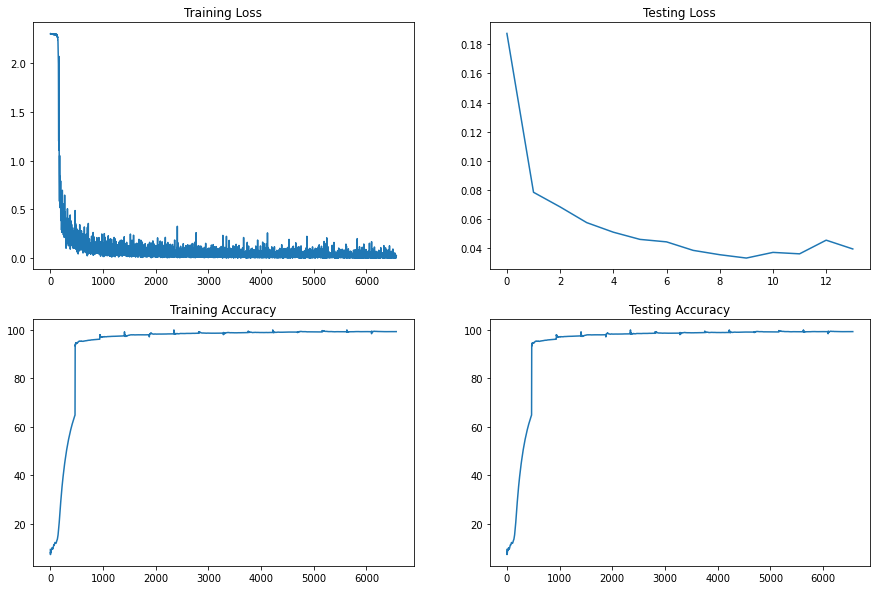

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].plot(train_losses)
axs[0,0].set_title("Training Loss")
axs[1,0].plot(train_acc)
axs[1,0].set_title("Training Accuracy")

axs[0,1].plot(test_losses)
axs[0,1].set_title("Testing Loss")
axs[1,1].plot(train_acc)
axs[1,1].set_title("Testing Accuracy")
